In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('data/HR-dataset.csv')

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

target = 'left'
features = df.columns.drop(target)
features = features.drop('empid')  # Удалим идентификатор пользователя как нерепрезентативный признак
print(features)

X, y = df[features].copy(), df[target]

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'dept', 'salary'],
      dtype='object')


In [65]:
salary_ordinals = {'low': 1, 'medium': 2, 'high': 3}

X['dept'] = X['dept'].apply(X['dept'].value_counts().get)
X['salary'] = X['salary'].apply(salary_ordinals.get)

In [66]:
X['salary']

0        1
1        2
2        2
3        1
4        1
        ..
14994    1
14995    1
14996    1
14997    1
14998    1
Name: salary, Length: 14999, dtype: int64

In [67]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

In [68]:
X

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.341235,-0.411165,-0.147412,1.370267,-0.933368
1,0.752814,0.840707,0.971113,1.220423,1.713436,-0.411165,-0.147412,1.370267,0.636092
2,-2.022479,0.957554,2.593763,1.420657,0.343655,-0.411165,-0.147412,1.370267,0.636092
3,0.431041,0.899131,0.971113,0.439508,1.028546,-0.411165,-0.147412,1.370267,-0.933368
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.341235,-0.411165,-0.147412,1.370267,-0.933368
...,...,...,...,...,...,...,...,...,...
14994,-0.856051,-0.853580,-1.462863,-1.002181,-0.341235,-0.411165,-0.147412,-0.064033,-0.933368
14995,-0.976716,-1.379394,-1.462863,-0.821970,-0.341235,-0.411165,-0.147412,-0.064033,-0.933368
14996,-0.976716,-1.087275,-1.462863,-1.162368,-0.341235,-0.411165,-0.147412,-0.064033,-0.933368
14997,-2.022479,1.424944,1.782438,1.580845,0.343655,-0.411165,-0.147412,-0.064033,-0.933368


In [69]:
def estimate_accuracy(clf, X, y, cv=5):
    return cross_val_score(clf, X, y, cv=5, scoring='f1').mean()

In [70]:
tree = DecisionTreeClassifier(max_depth=30)
print("Decision tree:", estimate_accuracy(tree, X, y))

Decision tree: 0.9450045314500757


In [71]:
bagging_trees = BaggingClassifier(tree)
print("Decision tree bagging:", estimate_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.9745837353643367


In [72]:
random_tree = DecisionTreeClassifier(max_features=int(np.sqrt(len(features))), max_depth=30)
print("Random tree:", estimate_accuracy(random_tree, X, y))

Random tree: 0.9540713833978115


In [73]:
bagging_random_trees = BaggingClassifier(random_tree)
print("Random tree bagging:", estimate_accuracy(bagging_random_trees, X, y))

Random tree bagging: 0.9791073387690844


Стандартная эвристика: в задаче классификации брать квадратный корень числа признаков, а в задаче регрессии — треть числа признаков.

In [74]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    max_features=int(np.sqrt(len(features))),
    max_depth=30)
print("Random Forest:", estimate_accuracy(random_forest, X, y))

Random Forest: 0.9829834277014811


In [75]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    max_features=int(np.sqrt(len(features))),
    max_depth=30,
    oob_score=True,
    n_jobs=-1
)
random_forest.fit(X, y)
random_forest.oob_score_.mean()

0.9929995333022201

In [76]:
lr = LogisticRegression(solver='saga', max_iter=200)
lr.fit(X, y)
print("LR:", estimate_accuracy(lr, X, y))

LR: 0.44172459802488306


In [77]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    random_state=42
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.4365451576623669


In [78]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    max_features=0.5,
    random_state=42
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.22025904904521182


In [79]:
def plot_predictions(X, y, clf, proba=False, points_size=7, xlabel='x', ylabel='y'):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_std, y_std = data.std(axis=0)
        x_min, x_max = data[:, 0].min() - x_std / 2, data[:, 0].max() + x_std / 2
        y_min, y_max = data[:, 1].min() - y_std / 2, data[:, 1].max() + y_std / 2
        return np.meshgrid(np.linspace(x_min, x_max, num=200),
                           np.linspace(y_min, y_max, num=200))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.coolwarm, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.coolwarm, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return clf

ПРАКТИКА

Задание 5.7.1
0.0/2.0 points (graded)
Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score.

Эту величину введите в поле для ответа (Ваше значение должно попасть в заданный интервал).

In [113]:
from sklearn.datasets import load_digits

In [114]:
digits = load_digits()
X = digits['data']
y = digits['target']

In [115]:
digits.DESCR

".. _digits_dataset:\n\nOptical recognition of handwritten digits dataset\n--------------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 1797\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttps://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixel

In [116]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [117]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [118]:
def estimate_accuracy(clf, X, y, cv=5):
    return cross_val_score(clf, X, y, cv=cv, n_jobs = -1).mean()

In [137]:
tree = DecisionTreeClassifier()
print("Decision tree:", estimate_accuracy(tree, X, y, 10))

Decision tree: 0.8258038485412786


In [138]:
cross_val_score(tree, X, y, cv=10, n_jobs = -1).mean()

0.8308193668528864

Задание 5.7.2


Теперь давайте обучим BaggingClassifier на основе DecisionTreeClassifier. Из sklearn.ensemble импортируйте BaggingClassifier, все параметры задайте по умолчанию. Нужно изменить только количество базовых моделей, задав его равным .

В поле для ответа введите качество работы получившегося классификатора (ваше значение должно попасть в заданный интервал).

Подумайте, какие выводы можно сделать из соотношения качества одиночного дерева и бэггинга деревьев?

In [139]:
from sklearn.ensemble import BaggingClassifier

In [155]:
random_logreg = BaggingClassifier(
    n_estimators=100
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y, 10))

Bagging for LR: 0.9253786468032278


Задание 5.7.3

Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех  признаках, а на  случайных признаках.

В поле для ответа введите качество работы получившегося классификатора (Ваше значение должно попасть в заданный интервал).

Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три,  тоже имеет место быть. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков, добиваясь лучшего качества на кросс-валидации.

In [156]:
X.shape[1]

64

In [157]:
n_features=int(np.sqrt(X.shape[1]))

In [158]:
bc = BaggingClassifier(
    n_estimators=100,
    max_features=n_features
)
print("Bagging accuracy:", estimate_accuracy(bc, X, y, 10))


Bagging accuracy: 0.930996275605214


Задание 5.7.4

In [160]:
random_logreg = BaggingClassifier(
    n_estimators=100,
    max_features=n_features,
    random_state=42
)
print("Bagging accuracy:", estimate_accuracy(random_logreg, X, y, 10))

Bagging accuracy: 0.9298851644941031


Задание 5.7.5

In [161]:
from sklearn.ensemble import RandomForestClassifier

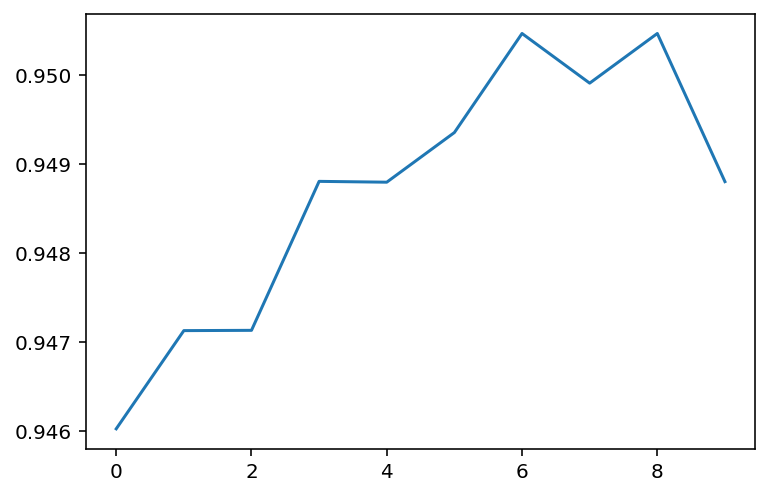

In [162]:
rfc_score = []
for i in range(50, 150, 10):
    # сначала получим предсказанные кластеры при помощи метода кластеризации
    rfc = RandomForestClassifier(
            n_estimators=i,
            max_features=n_features,
            random_state=42        
            )

    # теперь посчитаем коэффициент силуэта
    rfc_score.append(estimate_accuracy(rfc, X, y, 10));
plt.plot(rfc_score)

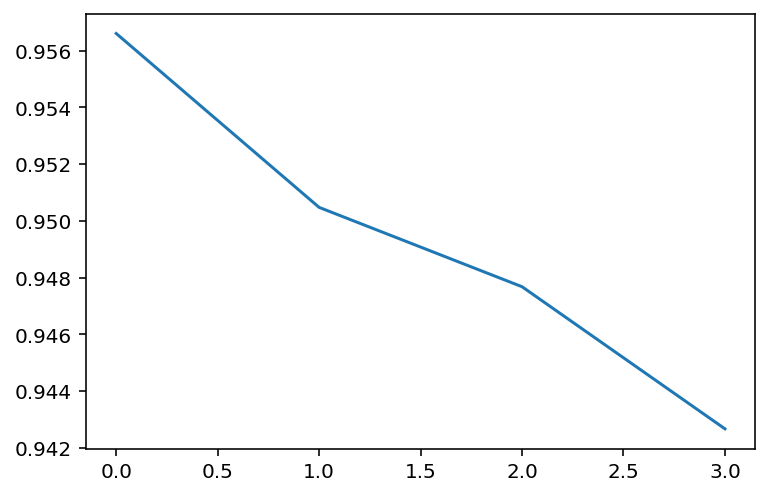

In [165]:
rfc_score = []
for i in range(5, 25, 5):
    n_features= int( X.shape[1] * i / 100)
    # сначала получим предсказанные кластеры при помощи метода кластеризации
    rfc = RandomForestClassifier(
            n_estimators=110,
            max_features=n_features,
            random_state=42        
            )

    # теперь посчитаем коэффициент силуэта
    rfc_score.append(estimate_accuracy(rfc, X, y, 10));
plt.plot(rfc_score)

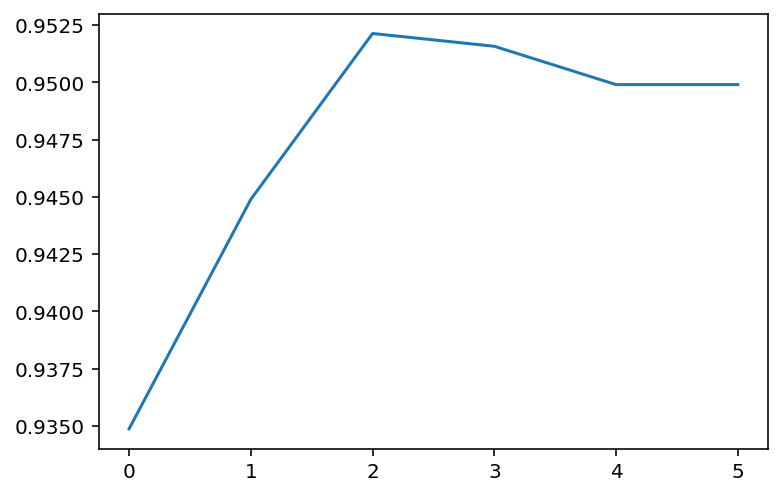

In [167]:
rfc_score = []
for i in range(8, 20, 2):
    n_depth = i
    # сначала получим предсказанные кластеры при помощи метода кластеризации
    rfc = RandomForestClassifier(
            n_estimators=110,
            max_features=10,
            max_depth = n_depth,
            random_state=42
            )

    # теперь посчитаем коэффициент силуэта
    rfc_score.append(estimate_accuracy(rfc, X, y, 10));
plt.plot(rfc_score)